# Introducing DOLO

### What is DOLO? 

A Python-based language to write and solve a variety of economic models (often dynamic, often stochastic). It uses a simple classification syntax written in YAML (Yet Another Markup Language) to express model objects, which can then be solved in a Python console or Jupyter Notebook.

Up front, one of the biggest advantages of DOLO is that it can serve as a straightforward replacement of Dynare for solving DSGE models. We'll talk about this advantage a lot as we go on.

### Jumping right in...

DOLO can be installed very easily with instructions from the website (http://dolo.readthedocs.io/en/doc/)

If you have Anaconda, you can quickly install Dolo with:
* ``pip install dolo``

Website provides a good intro to the Dolo package, but for further information you'll often have to go looking through the code yourself. Most of the algorithms we'll be using can be found in, for example: 
* ``C:\Users\James\Anaconda3\Lib\site-packages\dolo\algos``
* For example, ``dtcscc`` holds scripts that solve "Discrete Transition Continuous State Continuous Controls" models

### An RBC model example

Let's begin by importing DOLO and an example RBC model file from EconForge. We then print the model to see what's inside. 

In [2]:
from dolo import *
import numpy as np 
import matplotlib.pyplot as plt

filename = ('https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rbc.yaml')

pcat(filename)    # Print the model file

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72


The first thing we'll want to do is read, import, and check the steady state of the model object. Doing this with ``yaml_import``, we'll be able to see what "kind" of model has been imported. In this case we have a Discrete Transiton Continuous State Continuous Controls model. 

Note that we do not need to include the steady state equations in the model file, these can be computed later. 

In [3]:
model = yaml_import(filename)

Model type detected as 'dtcscc'


Let's take a look at the residuals from the solution for the steady state of the model:

In [4]:
print(model) 


Model object:
------------

- name: "Real Business Cycle"
- type: "dtcscc"
- file: "https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rbc.yaml

- residuals:

    transition
        1   : 0.0000 : z = (1-rho)*zbar + rho*z(-1) + e_z
        2   : 0.0000 : k = (1-delta)*k(-1) + i(-1)

    arbitrage
        1   : 0.0000 : 1 - beta*(c/c(1))**(sigma)*(1-delta+rk(1))   | 0 <= i <= inf
        2   : 0.0000 : chi*n**eta*c**sigma - w                       | 0 <= n <= inf

    auxiliary
        1   : 0.0000 : y = z*k**alpha*n**(1-alpha)
        2   : 0.0000 : c = y - i
        3   : 0.0000 : rk = alpha*y/k
        4   : 0.0000 : w = (1-alpha)*y/n

    value
        1   : 0.0000 : V = log(c) + beta*V(1)




## Approximate model solutions

We can solve models with several DOLO methods.
* Pertubation methods: 
    * Only first order for me; I seem to be missing a package for higher orders
* Global solutions: 
    * Works very well 
* Dynare: 
    * Looks like it is still under development

Let's first use a first order pertubation method (i.e. a linear approximation) to solve the model using the ``approximate_controls`` function. This will use a Schur/QZ decomposition method, which is the same as in (Matlab's) Dynare. We will use the ``dr_`` prefix to denote a solved decision rule object. 

One nice thing about DOLO is that the solved decision rules are much nicer to work with than in (Matlab's) Dynare.

In [5]:
dr_pert = approximate_controls(model, order=1)

Next, let's find a global solution to the model. The elements of the code are as follows:
* ``time_iteration``: is a function that finds a global solution using backward time-iteration. The algorithm iterates on the residuals of the arbitrage equations, in this case the Euler equation and labor supply equation. 

* ``interp_type`` lets us use either ``smolyak`` interpolation or polynomial ``spline`` interpolation for the policy functions. 

    * For splines: ``interp_type`` sets the order of the polynomial interpolation in each state/dimension.
    * For Smolyak: ``smolyak_order`` sets the order of Smolyak interpolation.

* ``pert_order``: determines the pertubuation order of the model solution which is given as an initial policy. For example, setting equal to one begins with a policy that comes from linear approximation. (Not clear what happens if the model has inequality constraints...)

* ``verbose``: setting to true makes the number of iterations visible.

Let's solve using both spline and Smolyak methods. In each case, we'll use 3rd order polynomials. 

In [6]:
dr_global_spl = time_iteration(model, pert_order=1, verbose=False, interp_type="spline", interp_orders=[3,3])


In [7]:
dr_global_smol = time_iteration(model, pert_order=1, verbose=False, interp_type="smolyak", smolyak_order=3)


## Plotting decision rules

Next, let's plot the three kinds of solution: linear approximation, cubic spline approximation, and third order Smolyak approximation. We look at the decision rules for investment and labor supply. 

Note how much easier it is to observe decision rules than in Dynare.

The key command is ``plot_decision_rule``, which takes the decision rule object as an input (and other standard plot inputs).

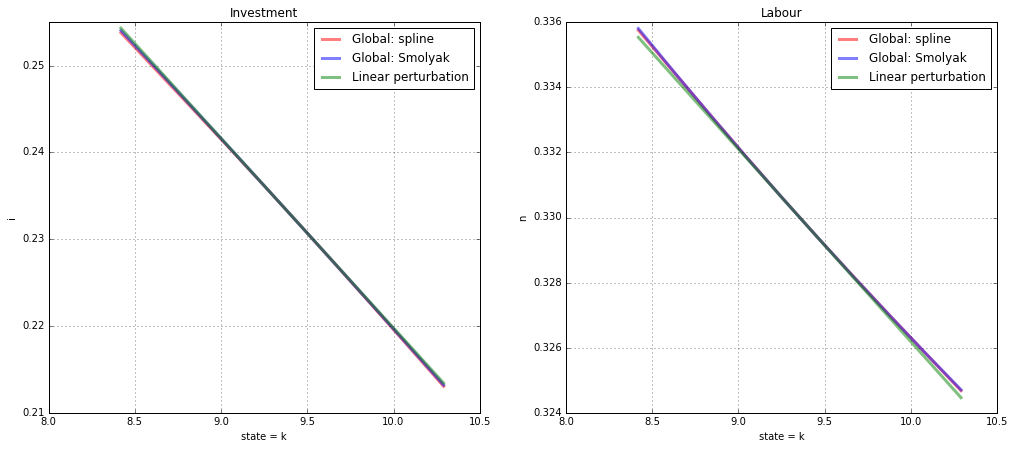

In [8]:
%matplotlib inline

# Get bounds for the approximations
spl_bounds    = [numpy.min(dr_global_spl.grid[:,1]), numpy.max(dr_global_spl.grid[:,1])]
smol_bounds    = [numpy.min(dr_global_smol.grid[:,1]), numpy.max(dr_global_smol.grid[:,1])]

plt.figure(figsize=(17, 7))

plt.subplot(121)
plot_decision_rule(model, dr_global_spl, 'k', 'i', label='Global: spline', bounds=spl_bounds, linewidth=3, alpha=0.5,color='r')
plot_decision_rule(model, dr_global_smol, 'k', 'i', label='Global: Smolyak', bounds=spl_bounds, linewidth=3, alpha=0.5,color='b')
plot_decision_rule(model, dr_pert, 'k', 'i', label='Linear perturbation', bounds=spl_bounds, linewidth=3, alpha=0.5,color='g')
plt.ylabel('i')
plt.title('Investment')
plt.legend()
plt.grid()

plt.subplot(122)
plot_decision_rule(model, dr_global_spl, 'k', 'n', label='Global: spline', bounds=spl_bounds, linewidth=3, alpha=0.5,color='r')
plot_decision_rule(model, dr_global_smol, 'k', 'n', label='Global: Smolyak', bounds=spl_bounds, linewidth=3, alpha=0.5,color='b')
plot_decision_rule(model, dr_pert, 'k', 'n', label='Linear perturbation', bounds=spl_bounds, linewidth=3, alpha=0.5,color='g')
plt.ylabel('n')
plt.title('Labour')
plt.legend()
plt.grid()

plt.show()

## Comparative statics

Next, let's carry out a comparative statics exercise by changing the value of the depreciation rate $\delta$. We'll just use the linearized model for this. 

First, we'll create a set of linearized models, each solved with a different value of delta. We put these models into a list object, and then call each of them when plotting the associated decision rules. 

The ``model.set_calibration`` command lets us change the calibration of the model object. We then append our chosen model approximation to a list of decision rules, ``drs``.  

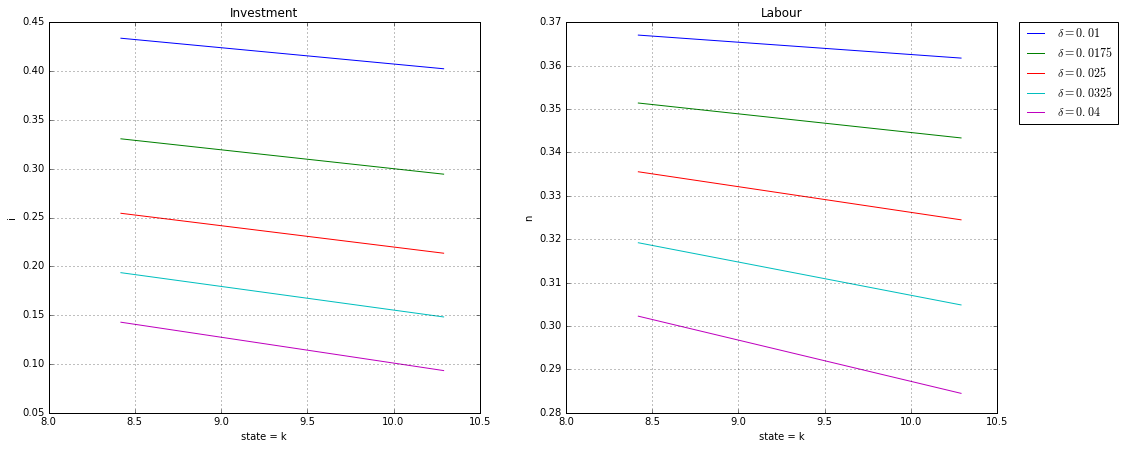

In [9]:
original_delta=model.calibration_dict['delta'] 

drs = []
delta_values = np.linspace(0.01, 0.04,5)
for val in delta_values:
    model.set_calibration(delta=val)                    # Change calibration
    drs.append(approximate_controls(model, order=1))    # appending another model object to the list

    
plt.figure(figsize=(17, 7))

# Plot investment decision rules
plt.subplot(121)
for i,dr in enumerate(drs):
    plot_decision_rule(model, dr, 'k', 'i',
                       label='$\delta={}$'.format(delta_values[i]), 
                       bounds=spl_bounds)
plt.ylabel('i')
plt.title('Investment')
plt.grid()

# Plot labor decision rules
plt.subplot(122)
for i,dr in enumerate(drs):
    plot_decision_rule(model, dr, 'k', 'n',
                       label='$\delta={}$'.format(delta_values[i]), 
                       bounds=spl_bounds)
plt.ylabel('n')
plt.title('Labour')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

# Reset model back to the original calibration
model.set_calibration(delta=original_delta)

## Simulations/Impulse response functions

Now we turn to simulating the model. From now on we'll just deal with the linear and spline approximations. 

First, reload the model with the original calibration.

In [10]:
# Reload the model with the original calibration
model = yaml_import(filename)
dr_pert = approximate_controls(model, order=1)
dr_global_spl = time_iteration(model, pert_order=1, verbose=False, interp_type="spline", interp_orders=[3,3])

Model type detected as 'dtcscc'


Now, we start the simulation at the model steady state, and then get the model shocks. 

In [11]:
s0        = model.calibration['states']
sigma2_ez = model.covariances

print(str(model.symbols['states'])+'='+str(s0))   # Print the steady state values of each state variable

['z', 'k']=[ 1.          9.35497829]


We can simulate functions easily using the ``simulate`` function. This is very similar to Dynare's ``stoch_simul`` command: it both simulates and creates IRFs. It's inputs are:
* ``model``: our RBC model object
* ``dr_``: the solved decision rule of choice
* ``s1``: the position from where all simulations start, in this case from the date of the shock
* ``n_exp``: the number of simulations. Set to 0 to produce IRFs
* ``horizon``: the number of simulated periods

The ``simulate`` command then returns a Pandas table of size $horizon×numvar$.

In [12]:
s1     = s0.copy()         # Copy steady states 
s1[0] *= 1.05               # Set size of shock to 5% larger than steady state value

irf_glob = simulate(model, dr_global_spl, s1, n_exp=0, horizon=40 )     # Simulate spline model 
irf_pert = simulate(model, dr_pert, s1, n_exp=0, horizon=40 )       # Simulate linear model

Now let's plot the impulse responses to a 5% shock to productivity: 

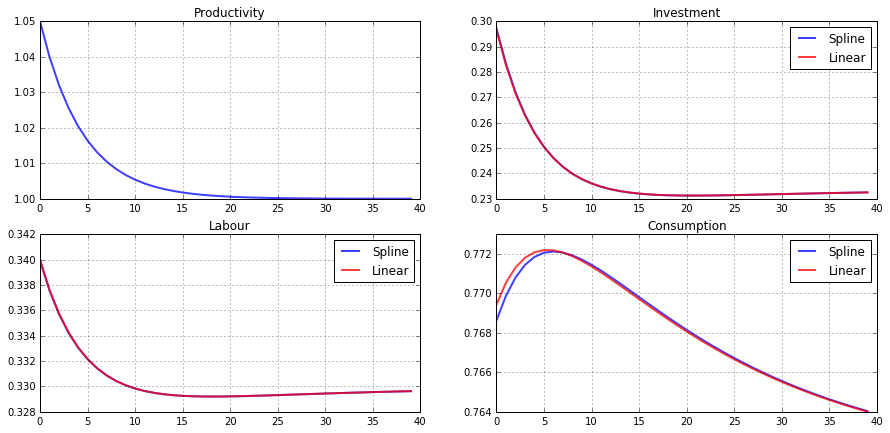

In [13]:
plt.figure(figsize=(15, 7))

plt.subplot(221)
plt.plot(irf_glob['z'],linewidth=2, alpha=0.75,color='b')
plt.title('Productivity')
plt.grid()

plt.subplot(222)
plt.plot(irf_glob['i'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['i'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Investment')
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(irf_glob['n'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['n'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Labour')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(irf_glob['c'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['c'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Consumption')
plt.legend()
plt.grid()

plt.show()

Now let's try again with a 20% shock. We can see how much different the spline and linear approximations are in the face of large shocks:  

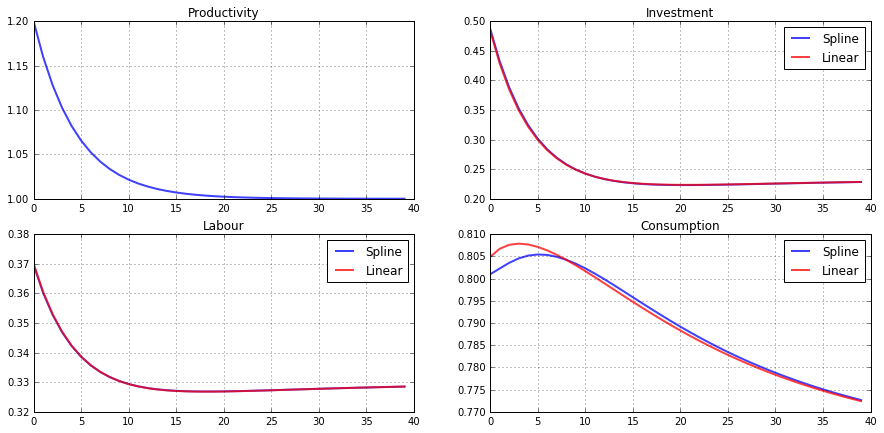

In [14]:
s1     = s0.copy()         # Copy steady states 
s1[0] *= 1.2               # Set size of shock to 5% larger than steady state value

irf_glob = simulate(model, dr_global_spl, s1, n_exp=0, horizon=40 )     # Simulate spline model 
irf_pert = simulate(model, dr_pert, s1, n_exp=0, horizon=40 )       # Simulate linear model

plt.figure(figsize=(15, 7))

plt.subplot(221)
plt.plot(irf_glob['z'],linewidth=2, alpha=0.75,color='b')
plt.title('Productivity')
plt.grid()

plt.subplot(222)
plt.plot(irf_glob['i'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['i'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Investment')
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(irf_glob['n'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['n'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Labour')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(irf_glob['c'],linewidth=2, alpha=0.75,color='b',label='Spline')
plt.plot(irf_pert['c'],linewidth=2, alpha=0.75,color='r',label='Linear')
plt.title('Consumption')
plt.legend()
plt.grid()

plt.show()

### Approximation errors

We can compute the approximation errors for the optimality conditions: 

* $$EulerError = 1 - \beta E \left[ \left( \frac{C_{t+1}}{C_t} \right)^{\sigma}( 1- \delta + r_{k,t+1} ) \right] $$
* $$LaborSupplyError = w_t - \chi n_t^{\eta} C_t^{\sigma} $$ 

First, let's look at the maximum and mean errors (i.e. using the ergodic distribution of the model) over the state space for each of the approximations. We use the ``omega`` function to do this. We then print the errors for each equation.

In [23]:
# Reload the model with the original calibration
model = yaml_import(filename)
# dr_pert = approximate_controls(model, order=1)
dr_global_spl = time_iteration(model, pert_order=1, verbose=False, interp_type="spline", interp_orders=[4,4])

Model type detected as 'dtcscc'


In [24]:
from dolo.algos.dtcscc.accuracy import omega

err_pert = omega(model, dr_pert)
print("Linear approximation\n")
print(err_pert)
print("--------------\n")

err_spl = omega(model, dr_global_spl)
print("Cubic spline approximation\n")
print(err_spl)
print("--------------\n")

err_smol = omega(model, dr_global_smol)
print("Smolyak approximation\n")
print(err_smol)




Linear approximation

Euler Errors:
- max_errors     : [ 0.00082703  0.00646158]
- ergodic        : [ 0.00018773  0.00084238]

--------------

Cubic spline approximation

Euler Errors:
- max_errors     : [ 0.00020388  0.00025505]
- ergodic        : [  1.48554280e-04   8.03166294e-05]

--------------

Smolyak approximation

Euler Errors:
- max_errors     : [  1.38008613e-04   2.28991817e-06]
- ergodic        : [  1.32367122e-04   6.62075500e-07]



We can also visualize the errors over the state space:

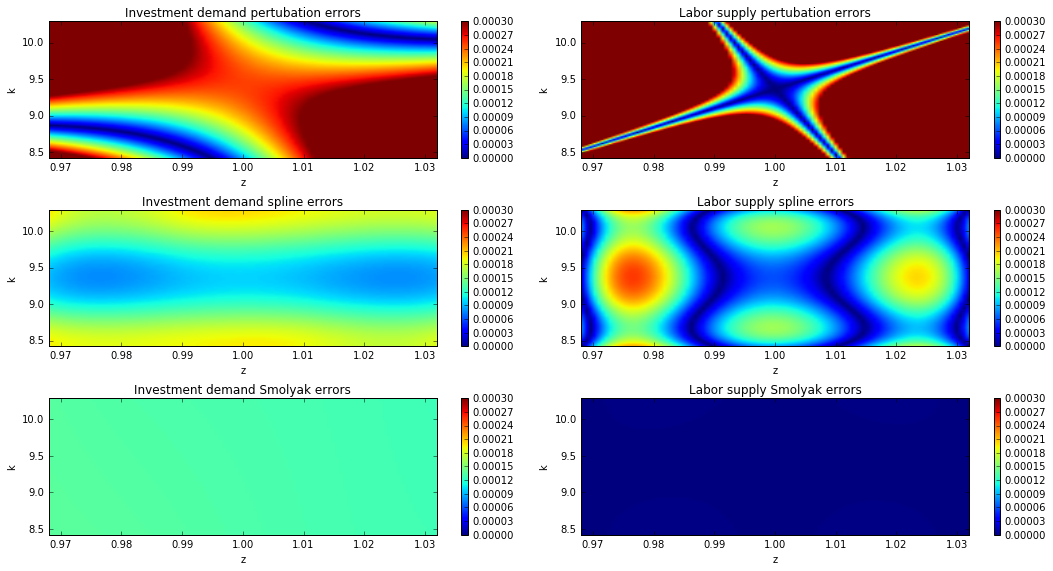

In [25]:
a = err_pert['domain'].a
b = err_pert['domain'].b
orders = err_pert['domain'].orders
errors = np.concatenate((err_pert['errors'].reshape( orders.tolist()+[-1] ),
                      err_spl['errors'].reshape( orders.tolist()+[-1] ),
                      err_smol['errors'].reshape( orders.tolist()+[-1] )),
                     2)

plt.figure(figsize=(15,8))

titles=["Investment demand pertubation errors",
        "Labor supply pertubation errors",
        "Investment demand spline errors",
        "Labor supply spline errors",
       "Investment demand Smolyak errors",
        "Labor supply Smolyak errors"]

for i in range(6):

    plt.subplot(3,2,i+1)
    imgplot = plt.imshow(errors[:,:,i], origin='lower',
                     extent=( a[0], b[0], a[1], b[1]), aspect='auto')
    imgplot.set_clim(0,3e-4)
    plt.colorbar()
    plt.xlabel('z')
    plt.ylabel('k')
    plt.title(titles[i])
    
plt.tight_layout()

## Conclusion

#### Pros
* DOLO is fairly easy to use 
    * Much easier to access decision rule objects than Matlab's Dynare
* Implements a range of approximation methods
* At least as fast as Matlab's Dynare

#### Cons
* Still very much "In Development"
* Some functions not working (higher order pertubations, Dynare)
* Not yet well-documented 
* Not yet well-used (far less online help than for Matlab's Dynare)
* Does not have Dynare's Ramsey Policy functions